In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Mon Jan 22 10:17:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   53C    P0   281W / 300W |  27899MiB / 80994MiB |     14%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -3
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.999

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.999_1e-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 77236, model_list, optimizer_list)

total 76952
-rw-rw-r-- 1 scpark scpark     1381  1월 22 10:17 events.out.tfevents.1705886113.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 22 10:15 events.out.tfevents.1705886050.GPUSVR11
-rw-rw-r-- 1 scpark scpark    17026  1월 22 10:15 events.out.tfevents.1705886056.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 10:13 save_77236
-rw-rw-r-- 1 scpark scpark 11458662  1월 22 10:13 events.out.tfevents.1705863474.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 09:38 save_70000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 08:50 save_60000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 08:01 save_50000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 07:12 save_40000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 06:24 save_30000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 05:35 save_20000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 04:46 save_10000
-rw-rw-r-- 1 scpark scpark  7470716  1월 22 03:58 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

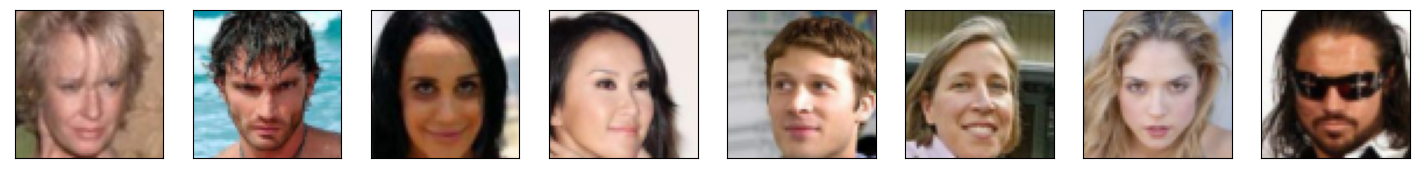

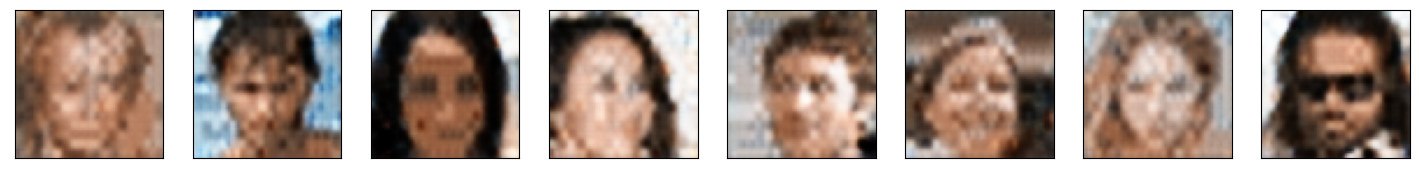

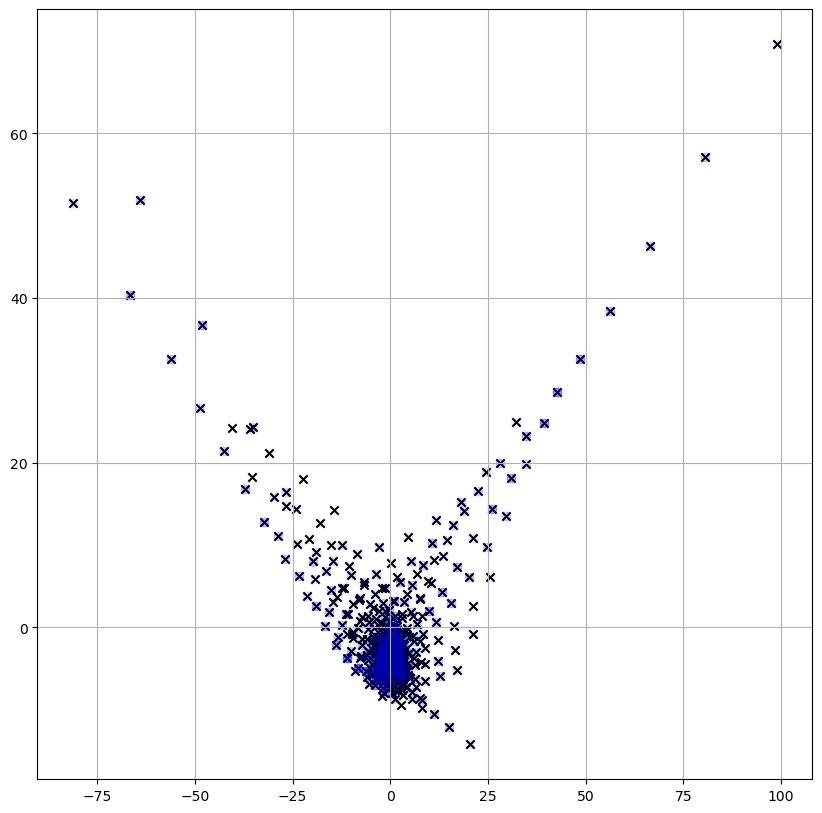

84001
lse_loss -107.79717254638672
commit_loss 0.004827565047889948
recon_loss 0.00020870400476269424
84002
lse_loss -70.12158966064453
commit_loss 0.0056122359819710255
recon_loss 0.00020317849703133106
84003
lse_loss -58.258399963378906
commit_loss 0.005066931247711182
recon_loss 0.00020514638163149357
84004
lse_loss -36.889503479003906
commit_loss 0.00495464913547039
recon_loss 0.0002404193946858868
84005
lse_loss -77.36710357666016
commit_loss 0.0048100873827934265
recon_loss 0.00021963664039503783
84006
lse_loss -85.51342010498047
commit_loss 0.0054707955569028854
recon_loss 0.00021442386787384748
84007
lse_loss -59.90911102294922
commit_loss 0.004756472073495388
recon_loss 0.00019263310241512954
84008
lse_loss -75.76239776611328
commit_loss 0.004899650812149048
recon_loss 0.00020318906172178686
84009
lse_loss -84.49103546142578
commit_loss 0.004801786504685879
recon_loss 0.00019964463717769831
84010
lse_loss -75.12653350830078
commit_loss 0.004774920176714659
recon_loss 0.0001986

84083
lse_loss 40.98619842529297
commit_loss 0.004688588436692953
recon_loss 0.000192463441635482
84084
lse_loss -78.33890533447266
commit_loss 0.004854490049183369
recon_loss 0.0001887955004349351
84085
lse_loss -32.45519256591797
commit_loss 0.00492856465280056
recon_loss 0.00019578597857616842
84086
lse_loss 43.168846130371094
commit_loss 0.004456263035535812
recon_loss 0.00019267438619863242
84087
lse_loss -64.86502838134766
commit_loss 0.004552393686026335
recon_loss 0.00020952994236722589
84088
lse_loss -27.345542907714844
commit_loss 0.004827843047678471
recon_loss 0.00019328176858834922
84089
lse_loss -86.14989471435547
commit_loss 0.00498957047238946
recon_loss 0.0001921685616252944
84090
lse_loss -87.67528533935547
commit_loss 0.0046174111776053905
recon_loss 0.00019138310744892806
84091
lse_loss -66.67423248291016
commit_loss 0.004751633387058973
recon_loss 0.0001907402474898845
84092
lse_loss -50.643592834472656
commit_loss 0.004851934965699911
recon_loss 0.0002042821142822

84165
lse_loss 7.477134704589844
commit_loss 0.004791354760527611
recon_loss 0.00018506214837543666
84166
lse_loss -67.1786117553711
commit_loss 0.004882770590484142
recon_loss 0.00021522765746340156
84167
lse_loss 14.078865051269531
commit_loss 0.005084478296339512
recon_loss 0.0002215084241470322
84168
lse_loss -64.38594818115234
commit_loss 0.005307598505169153
recon_loss 0.00020989245967939496
84169
lse_loss -95.3894271850586
commit_loss 0.004622794687747955
recon_loss 0.00019378529395908117
84170
lse_loss -6.218391418457031
commit_loss 0.004439434036612511
recon_loss 0.00020879096700809896
84171
lse_loss -66.3456802368164
commit_loss 0.004501095972955227
recon_loss 0.0002013452467508614
84172
lse_loss -2.2397842407226562
commit_loss 0.005123901646584272
recon_loss 0.00020029241568408906
84173
lse_loss -69.4384536743164
commit_loss 0.005450891796499491
recon_loss 0.0001896842586575076
84174
lse_loss -80.76203155517578
commit_loss 0.0052492860704660416
recon_loss 0.00019377598073333

84247
lse_loss 10.943824768066406
commit_loss 0.004676207900047302
recon_loss 0.00018737372010946274
84248
lse_loss 19.902610778808594
commit_loss 0.004693393595516682
recon_loss 0.0002828501455951482
84249
lse_loss -90.31073760986328
commit_loss 0.004369753412902355
recon_loss 0.00017659325385466218
84250
lse_loss -58.13043975830078
commit_loss 0.004622208885848522
recon_loss 0.00019917995086871088
84251
lse_loss -62.73993682861328
commit_loss 0.004402694292366505
recon_loss 0.0002222237817477435
84252
lse_loss -94.76807403564453
commit_loss 0.004499262198805809
recon_loss 0.0001826719380915165
84253
lse_loss -22.261131286621094
commit_loss 0.004789660684764385
recon_loss 0.0001779783342499286
84254
lse_loss 104.27977752685547
commit_loss 0.00444623501971364
recon_loss 0.00021979579469189048
84255
lse_loss -6.359413146972656
commit_loss 0.004752425942569971
recon_loss 0.00026218811399303377
84256
lse_loss -66.2811050415039
commit_loss 0.005276040639728308
recon_loss 0.0002285536320414

84329
lse_loss -72.5790786743164
commit_loss 0.00521042151376605
recon_loss 0.00021093603572808206
84330
lse_loss -11.949165344238281
commit_loss 0.004791314713656902
recon_loss 0.00018171194824390113
84331
lse_loss -69.45006561279297
commit_loss 0.004745840094983578
recon_loss 0.00017732537526171654
84332
lse_loss -89.65434265136719
commit_loss 0.005968863144516945
recon_loss 0.00020567156025208533
84333
lse_loss -105.13574981689453
commit_loss 0.004823683761060238
recon_loss 0.00019489559053909034
84334
lse_loss -58.05225372314453
commit_loss 0.004861573688685894
recon_loss 0.00019943492952734232
84335
lse_loss -30.667442321777344
commit_loss 0.005011916160583496
recon_loss 0.00022892891138326377
84336
lse_loss -99.8591079711914
commit_loss 0.004475786350667477
recon_loss 0.00018962574540637434
84337
lse_loss -106.08763885498047
commit_loss 0.005099101457744837
recon_loss 0.00022351802908815444
84338
lse_loss -64.99356842041016
commit_loss 0.004856913350522518
recon_loss 0.0002065354

84411
lse_loss -88.74652862548828
commit_loss 0.004370993468910456
recon_loss 0.00020911311730742455
84412
lse_loss -87.90249633789062
commit_loss 0.004842174239456654
recon_loss 0.00019546967814676464
84413
lse_loss -92.6288070678711
commit_loss 0.004405009560286999
recon_loss 0.00018602490308694541
84414
lse_loss -122.2127456665039
commit_loss 0.004390345886349678
recon_loss 0.00021685495448764414
84415
lse_loss -74.4902114868164
commit_loss 0.004522069822996855
recon_loss 0.00020845665130764246
84416
lse_loss -82.9789810180664
commit_loss 0.004869429860264063
recon_loss 0.00017798098269850016
84417
lse_loss -5.498985290527344
commit_loss 0.004406077321618795
recon_loss 0.00018547952640801668
84418
lse_loss -43.511878967285156
commit_loss 0.004294937010854483
recon_loss 0.000187693556654267
84419
lse_loss -75.40131378173828
commit_loss 0.004521805793046951
recon_loss 0.00017560301057528704
84420
lse_loss -53.429725646972656
commit_loss 0.004787529818713665
recon_loss 0.00023013367899

84493
lse_loss -77.65380096435547
commit_loss 0.004770693369209766
recon_loss 0.00019618093210738152
84494
lse_loss -31.26251983642578
commit_loss 0.0044784462079405785
recon_loss 0.00021040553110651672
84495
lse_loss -47.095909118652344
commit_loss 0.005274958908557892
recon_loss 0.0001964005350600928
84496
lse_loss -95.22663116455078
commit_loss 0.005387180484831333
recon_loss 0.00023511445033363998
84497
lse_loss -92.47325897216797
commit_loss 0.005127368960529566
recon_loss 0.0001913260784931481
84498
lse_loss 71.3010482788086
commit_loss 0.00470895366743207
recon_loss 0.00019168751896359026
84499
lse_loss -114.87690734863281
commit_loss 0.004911364056169987
recon_loss 0.00021821187692694366
84500
lse_loss -37.58910369873047
commit_loss 0.004493252374231815
recon_loss 0.00020212118397466838
84501
lse_loss -83.74663543701172
commit_loss 0.004582436755299568
recon_loss 0.00018100258603226393
84502
lse_loss -74.37732696533203
commit_loss 0.005711781792342663
recon_loss 0.0002102224098

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-6
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 1e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            model.eval()
            with torch.no_grad():
                data = model(data, latent_temp=1, quantize=True)
                
            writer.add_scalar('eval_recon_loss', data['recon_loss'].item(), step)    

            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

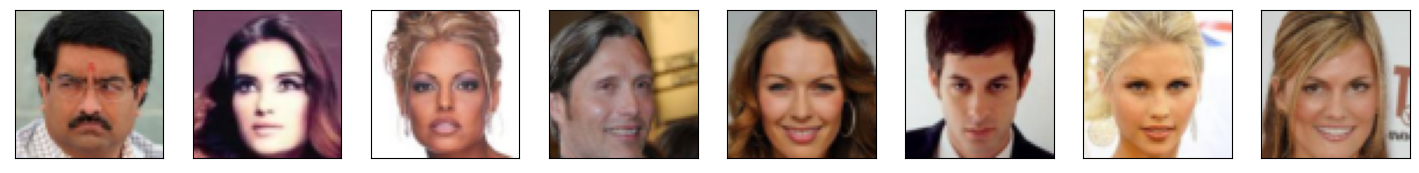

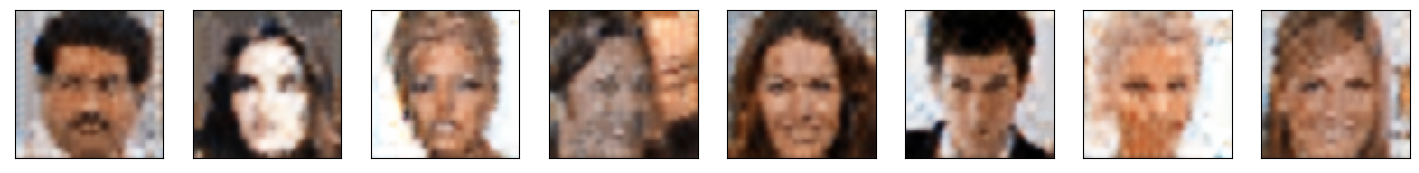

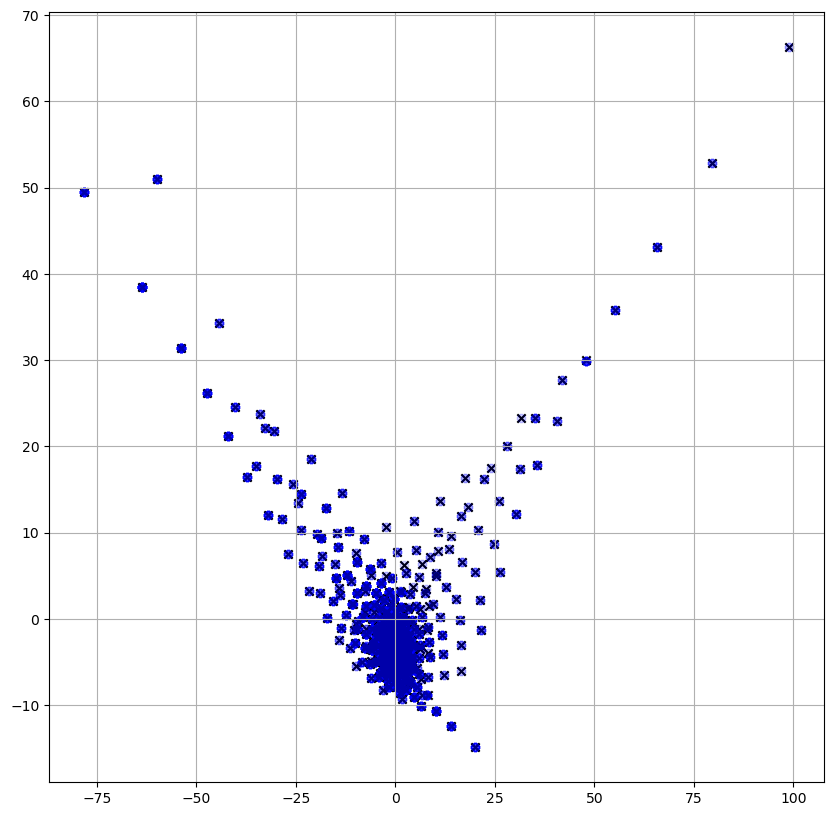

In [14]:
import matplotlib.pyplot as plt
display.clear_output()

model.eval()
with torch.no_grad():
    data = model(data, latent_temp=1, quantize=True)

writer.add_scalar('eval_recon_loss', data['recon_loss'].item(), step)    

x = data['x']
y = data['y']

plot(x)
plot(y)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 